# Toxic Comment Classification Challenge

(see https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/ ).   


##### control the use of the gpu

In [1]:
import time

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

##### import libraries

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import random
import h5py

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Read data

##### read data as dataframes with pandas

In [3]:
df_train = pd.read_table('data/train.csv',sep=',',header=0)
df_test = pd.read_table('data/test.csv',sep=',',header=0)
sample_submission = pd.read_table('data/sample_submission.csv',sep=',',header=0)

In [4]:
print("The training dataset contains",df_train.shape[0],"examples.")
print("The dataframe is composed of",df_train.shape[1],"columns:")
for i in range(len(df_train.columns)): print(df_train.columns[i])

The training dataset contains 159571 examples.
The dataframe is composed of 8 columns:
id
comment_text
toxic
severe_toxic
obscene
threat
insult
identity_hate


In [5]:
id_train = df_train['id']
x_train = df_train['comment_text']
y_train = df_train.iloc[:, 2:].values

id_test = df_test['id']
x_test = df_test['comment_text']

##### display some examples of comments

In [6]:
# select randomly some examples
examples = random.sample(range(x_train.shape[0]),3)

print(examples)
for ex in examples:
    print('Comment:  {}'.format(x_train[ex]))
    print('Labels:    {}'.format(y_train[ex]))
    print('\n')

[122538, 23520, 22124]
Comment:  lol u get no satisfaction
Labels:    [0 0 0 0 0 0]


Comment:  "

Relax guys. I'm sorry you thought it was rude; that's not what I was going for. I can be a poor judge of what will or won't be controversial. Just remember if you don't like it it's as simple as undoing it.

Now, Alec2011 says that I don't understand what the page is for. I'm sorry, there isn't anything that gives a specific ""mission statement"" for the article anywhere. So can you tell me? Just going on my own, I figured that if people want to know which songs are on which albums, they would just go to the album articles themselves. So having them organized that way seemed redundant to me. It seems that the only point to having an article like this is to show where the songs appear in the series. Because there is so much overlap between where they appear in the series and where they appear in the albums I did it this way.

And if your main complaint is that it's harder to edit because t

## Preprocess data

### Tokenizer

Create a tokenizer, which whill be use to vectorize the text of the comments (see: https://keras.io/preprocessing/text/ ).   
Then, fit the tokenizer on the training dataset and run it on the training and testing comments.

In [7]:
# create tokenizer
max_num_words = None

tokenizer = Tokenizer(num_words = max_num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
                      lower=True, split=' ', char_level=False, oov_token=None)

In [8]:
# fit tokenizer
tokenizer.fit_on_texts(list(x_train))

In [9]:
word_index = tokenizer.word_index # dictionnary of words whith their indexes (uniquely assigned integers)

voc_size = len(word_index)
print('The tokenizer founds {} unique tokens.' .format(voc_size))

The tokenizer founds 210337 unique tokens.


In [10]:
# run tokenizer
seq_train = tokenizer.texts_to_sequences(x_train)
seq_test = tokenizer.texts_to_sequences(x_test)

In [11]:
avg_len = np.mean([len(seq) for seq in seq_train])
std_len = np.std([len(seq) for seq in seq_train])
longest_len = max(len(seq) for seq in seq_train)
shortest_len = min(len(seq) for seq in seq_train)

print("The average length of the training sequences is {} with a standard deviation of {}.".format(avg_len,std_len))
print("The longest sequence has a size of {}, and the shortest only {}.".format(longest_len,shortest_len))

The average length of the training sequences is 68.22156908210138 with a standard deviation of 101.07344657013672.
The longest sequence has a size of 1403, and the shortest only 1.


In [12]:
# Fix a maximum length for the sequences
max_len = int(avg_len + std_len * 3)
print("The maximum length for the sequences is fixed at {}." .format(max_len))

The maximum length for the sequences is fixed at 371.


### pad_sequences

Pads the sequences to the same length : "max_size". Sequences shorter than "max_size" are padded with "0" and the end, and sequences longer are truncated.   
(see https://keras.io/preprocessing/sequence/ ).

In [13]:
data_train = pad_sequences(seq_train, maxlen=max_len, padding='post', truncating='post', value=0)
data_test = pad_sequences(seq_test, maxlen=max_len, padding='post', truncating='post', value=0)

print('Shape of training data tensor:', data_train.shape)
print('Shape of test data tensor:', data_test.shape)

Shape of training data tensor: (159571, 371)
Shape of test data tensor: (153164, 371)


### Embedding

### using word2vec

##### get embeddings

In [14]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_dim = next(iter(embeddings_index.values())).shape[0]

print("Found {} words vectors, with dim={}.".format(len(embeddings_index),embedding_dim))

Found 400000 words vectors, with dim=100.


###### construct the embedding matrix
It maps words to vectors in the specified embedding dimension ("embedding_dim").

In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector 
    # words not found in embedding index will be all-zeros.

print("Dimensions of the embedding matrix = {}".format(embedding_matrix.shape))

Dimensions of the embedding matrix = (210338, 100)


##### save embeddings

In [16]:
with h5py.File('embeddings_glove.6B.100d.h5', 'w') as hf:
    hf.create_dataset("glove.6B.100d",  data=embedding_matrix)

## Model

In [17]:
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Input, SpatialDropout1D, Reshape, Conv2D, MaxPool2D, Concatenate
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, Flatten
from keras import regularizers
from keras import Model

In [18]:
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=True)

In [19]:
model = Sequential()

# embedding layer
model.add(embedding_layer)

# convolution 1D layer
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())

# convolution 1D layer
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())
model.add(Dropout(0.3))

# fully connected layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(6, activation='sigmoid')) # multi-label

# summarize model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 371, 100)          21033800  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 371, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 185, 64)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 185, 64)           256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 185, 64)           20544     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
__________

In [20]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

Split the dataset into train and validation data :

In [21]:
X, X_val, y, y_val = train_test_split(data_train, y_train, train_size=0.1, shuffle=True)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


##### callbacks

- roc_auc_callback : evaluate the roc auc score on the validation data at each epoch
- EarlyStopping : interrupt the learning task when the model stop to improve
- ModelChekpoint : save the best model

In [22]:
class roc_auc_callback(Callback):
    def __init__(self, validation_data, interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.y_pred = np.zeros(self.y_val.shape)

    def on_epoch_end(self, epoch, logs={}):
        start = time.time()
        if epoch % self.interval == 0:
            y_pred = self.model.predict_proba(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['roc_auc_val'] = score
            dur = time.time() - start
            print('\r%.2fs - roc_auc_val: %s' % (dur, str(round(score,5)),), end=10*' '+'\n')

In [23]:
filepath = "logs_word2vec"
# create folder if not exists
if not os.path.exists(filepath):
    os.makedirs(filepath)

callbacks=[roc_auc_callback(validation_data=(X_val, y_val), interval=1),
           EarlyStopping(monitor='roc_auc_val', patience=10, min_delta=1e-4, verbose=1, mode='max'),
           ModelCheckpoint(os.path.join(filepath, 'best_model.h5'), monitor='roc_auc_val',\
                           save_best_only=True,save_weights_only=True, period=1, mode='max', verbose=1)]

In [24]:
%%time

history = model.fit(X, y, batch_size=128, epochs=100, validation_data=(X_val, y_val), 
                    callbacks=callbacks, verbose=1)

Train on 15957 samples, validate on 143614 samples
Epoch 1/100
15957/15957 [==============================] - 9s 564us/step - loss: 0.4535 - acc: 0.7822 - val_loss: 0.1093 - val_acc: 0.9702
10.59s - roc_auc_val: 0.81753          

Epoch 00001: roc_auc_val improved from -inf to 0.81753, saving model to logs_word2vec/best_model.h5
Epoch 2/100
15957/15957 [==============================] - 7s 467us/step - loss: 0.1370 - acc: 0.9577 - val_loss: 0.1043 - val_acc: 0.9672
10.31s - roc_auc_val: 0.86124          

Epoch 00002: roc_auc_val improved from 0.81753 to 0.86124, saving model to logs_word2vec/best_model.h5
Epoch 3/100
15957/15957 [==============================] - 7s 461us/step - loss: 0.0959 - acc: 0.9693 - val_loss: 0.0771 - val_acc: 0.9755
10.28s - roc_auc_val: 0.92633          

Epoch 00003: roc_auc_val improved from 0.86124 to 0.92633, saving model to logs_word2vec/best_model.h5
Epoch 4/100
15957/15957 [==============================] - 7s 462us/step - loss: 0.0754 - acc: 0.9746 -

### Plotting the results

Text(0.5,0,'epoch')

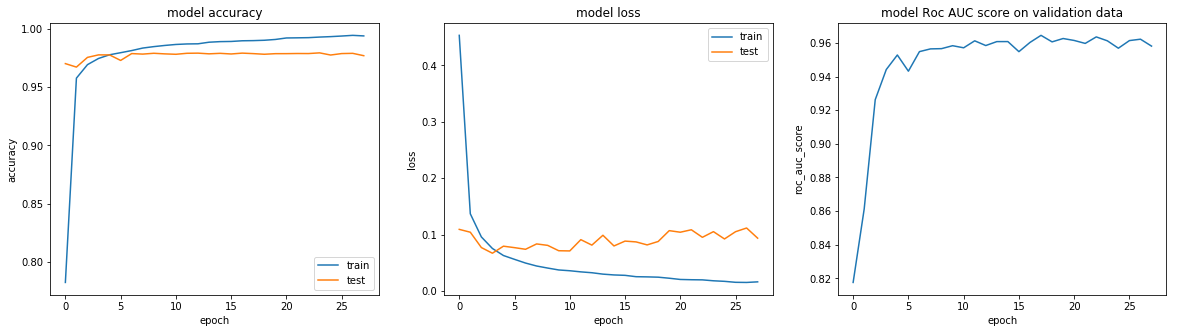

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

axes[0].plot(history.history['acc'], label='train')
axes[0].plot(history.history['val_acc'], label='test')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend()

axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='test')
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend()

axes[2].plot(history.history['roc_auc_val'])
axes[2].set_title('model Roc AUC score on validation data')
axes[2].set_ylabel('roc_auc_score')
axes[2].set_xlabel('epoch')


### Load best model

In [26]:
model.load_weights(filepath+'/'+'best_model.h5')

### Predict labels of test comments

In [27]:
pred = model.predict(data_test)

In [28]:
classes = []
for i in range(2,len(df_train.columns)):
    classes.append(df_train.columns[i])
print(classes)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [29]:
sample_submission[classes] = pred
sample_submission.to_csv("submission1.csv", index=False)